In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import pickle
from torch.utils.data import DataLoader, Dataset

In [2]:
import random
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(7)

In [3]:
from file_utils.mydata import MyData
from models.DBML_time import PSM
from models.DBML_storage import PSM_st

In [ ]:
data_name = 'Cell_Phones_and_Accessories'

In [4]:
with open('input_data/dataset_time_'+data_name+'.bin', 'rb') as f:
    datasets = pickle.load(f)

In [5]:
'''
dataset statistic
'''
datasets.productNum, datasets.userNum, datasets.wordNum

(10429, 27879, 81388)

# 测试模型

In [6]:
'''
实验参数
'''
embedding_dim = 50
out_size = 10
batch_size = 256
neg_sample_num = data_set.neg_sample_num
dataLen = len(data_set.train_data)
batch_num = int(dataLen/batch_size)
full_len = batch_num*batch_size
time_bin_num = len(data_set.time_data)
total_epoch = 2
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
'''
记录每个时间段的均值方差 初始化都为N(0, I) 第0个时间永远是N(0, I)
'''
user_time_latent = []
product_time_latent = []
word_time_latent = []
for t in range(time_bin_num+1):
    user_time_latent.append(dict())
    user_time_latent[t] = dict(zip(\
                                    list(datasets.id2user.keys()),[\
                                            [torch.zeros(embedding_dim), torch.ones(embedding_dim), 0.] for k in datasets.id2user.keys()
                                            ]\
                                  ))
    product_time_latent.append(dict())
    product_time_latent[t] = dict(zip(\
                                    list(datasets.id2product.keys()),[\
                                            [torch.zeros(embedding_dim), torch.ones(embedding_dim), 0.] for k in datasets.id2product.keys()
                                            ]\
                                  ))
    word_time_latent.append(dict())
    word_time_latent[t] = dict(zip(\
                                    list(datasets.id2word.keys()),[\
                                            [torch.zeros(embedding_dim), torch.ones(embedding_dim), 0.] for k in datasets.id2word.keys()
                                            ]\
                                  ))

In [8]:
'''
    def __init__(self, user_size, item_size, word_size, query_size, embedding_dim,\
                 max_query_len, max_review_len, batch_size, \
                 neg_num=5,sample_num=1,transfer_hidden_dim=100,\
                 sigma_parameter=1e-7, kl_parameter=1e-7,device=torch.device('cpu')):
'''
model = PSM(datasets.userNum, datasets.productNum, datasets.wordNum, datasets.queryNum, \
            embedding_dim, datasets.max_query_len, datasets.max_review_len,\
            batch_size, device=device)

CPU times: user 132 ms, sys: 20 ms, total: 152 ms
Wall time: 149 ms


In [9]:

'''
pos
0     1        2          3         4       5        6
(uid, pid_pos, qids_pos, len_pos, text_ids, len_r, time_bin_pos)
neg
neg_item,neg_user_word,neg_item_word
'''
pos, neg = datasets[0]

# forward(self, user, query, query_len, item_pos, items_neg):


u = torch.tensor(pos[0]).view(1,1)
p = torch.tensor(pos[1]).view(1,1)
q = torch.tensor(pos[2]).view(1,-1)
ql = torch.tensor(pos[3]).view(1,-1).float()
r = torch.tensor(pos[4]).view(1,-1)
rl = torch.tensor(pos[5]).view(1,-1)
ineg = torch.tensor(neg[0]).view(1,-1)
wneg = torch.tensor(neg[1]).view(1,-1)
time_bin = torch.tensor(pos[6]).view(1,-1)



prior_u_mean = user_time_latent[pos[6]][pos[0]][0].view(1,-1)
prior_u_std = user_time_latent[pos[6]][pos[0]][1].view(1,-1)
prior_i_mean = product_time_latent[pos[6]][pos[1]][0].view(1,-1)
prior_i_std = product_time_latent[pos[6]][pos[1]][1].view(1,-1)
prior_word_mean = torch.cat(\
                tuple(word_time_latent[pos[6]][i][0].view(1,-1) for i in pos[4]) , dim=0\
                             ).view(1,-1,embedding_dim)
prior_word_std = torch.cat(\
                tuple(word_time_latent[pos[6]][i][1].view(1,-1) for i in pos[4]) , dim=0\
                             ).view(1,-1,embedding_dim)

prior_i_mean_neg = torch.cat(tuple(product_time_latent[pos[6]][i][0].view(1,-1) for i in neg[0]) , dim=0).view(1,-1,embedding_dim)
prior_i_std_neg = torch.cat( tuple(product_time_latent[pos[6]][i][1].view(1,-1) for i in neg[0]) , dim=0).view(1,-1,embedding_dim)
prior_word_mean_neg = torch.cat(\
                tuple(word_time_latent[pos[6]][i][0].view(1,-1) for i in neg[1]) , dim=0\
                             ).view(1,-1,embedding_dim)
prior_word_std_neg = torch.cat(\
                tuple(word_time_latent[pos[6]][i][1].view(1,-1) for i in neg[1]) , dim=0\
                             ).view(1,-1,embedding_dim)


In [10]:
ineg.shape,wneg.shape,prior_i_mean_neg.shape,prior_u_mean.shape,prior_word_mean.shape,ql

(torch.Size([1, 5]),
 torch.Size([1, 5]),
 torch.Size([1, 5, 50]),
 torch.Size([1, 50]),
 torch.Size([1, 36, 50]),
 tensor([[3.]]))

In [13]:
'''
def forward(self, user, query, query_len, item_pos, items_neg,\
            prior_user_mean, prior_user_std,\
            prior_product_mean, prior_product_std,\
            prior_product_neg_mean, prior_product_neg_std,\
            word, word_neg, word_len,\
            prior_word_mean, prior_word_std,\
            prior_word_neg_mean, prior_word_neg_std):
            
return user_mean, user_std, query, \
        item_mean_pos, item_std_pos,\
        items_mean_neg, items_std_neg, \
        user_sample, product_sample, product_sample_neg, \
        loss, dis_pos, dis_neg
'''

user_mean, user_std, query, \
item_mean_pos, item_std_pos,\
items_mean_neg, items_std_neg, \
user_sample, product_sample, product_sample_neg, \
loss, dis_pos, dis_neg,\
word_mean_pos, word_std_pos, word_mean_neg, word_std_neg = model(u, q, ql, p, ineg,\
      prior_u_mean, prior_u_std,\
      prior_i_mean, prior_i_std,\
      prior_i_mean_neg, prior_i_std_neg,\
      r, wneg, rl,\
      prior_word_mean, prior_word_std,\
      prior_word_mean_neg, prior_word_std_neg, 'd'
     )
loss

tensor(9.4041, grad_fn=<AddBackward0>)

In [14]:
word_mean_pos.shape

torch.Size([1, 36, 50])

In [15]:
loss.grad_fn.next_functions

((<AddBackward0 at 0x7f8988f6b588>, 0), (<MulBackward0 at 0x7f8988f6ba20>, 0))

In [16]:
loss.backward()

In [17]:
loss

tensor(9.4041, grad_fn=<AddBackward0>)

# 训练模型

In [7]:
def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.
def mean_reciprocal_rank(r):
    return np.sum(r / np.arange(1, r.size + 1))
def hit_rate(r):
    if (np.sum(r) >= 0.9):
        return 1
    else:
        return 0
def get_query_laten(q_linear,query, query_len, max_query_len):
    '''
    input size: (batch, maxQueryLen)
    对query处理使用函数
    tanh(W*(mean(Q))+b)
    '''
    query_len = torch.tensor(query_len).view(1,-1).float()
    # size: ((batch, maxQueryLen))) ---> (batch, len(query[i]), embedding)
    # query len mask 使得padding的向量为0
    len_mask = torch.tensor([ [1.]*int(i.item())+[0.]*(max_query_len-int(i.item())) for i in query_len]).unsqueeze(2)
    query = query.mul(len_mask)
    query = query.sum(dim=1).div(query_len)
    query = q_linear(query).tanh()

    return query

In [8]:
#.  0    1         2        3        4         5       6
# (uid, pid_pos, qids_pos, len_pos, text_ids, len_r, time_bin_pos)
def get_all_eval(time_bin_num, datasets, embedding_dim, product_time_latent,\
                 start_time_bin,user_time_latent,word_time_latent,word_trans_linear):
    all_p_m = torch.empty(time_bin_num+1, datasets.productNum, embedding_dim)
    print()
    for ii in range(time_bin_num+1):
        k = 0
        for i in product_time_latent[ii].values():
            all_p_m[ii][k] = i[0]
            k+=1
    eval_dataset = datasets.test_data
    test_counter = 0
    all_hr = 0
    all_ndcg = 0
    all_mrr = 0
    for ii in range(len(eval_dataset)):
        td = eval_dataset[ii]
        '''
        应该定义一个训练过的user， 这里简单的先取训练过的时间段的用户
        '''
        if (td[6] >= 17 and td[0] in used_u):
            user = user_time_latent[td[6]+1][td[0]][0]
            query_len = td[3]
            query = torch.cat(tuple([word_time_latent[td[6]+1][i][0] for i in td[2]])).view(1,-1,embedding_dim)
            query = get_query_laten(word_trans_linear[td[6]+1], query, query_len, datasets.max_query_len)
            user_query = user+query
    #         uq_i = torch.empty(datasets.productNum)
            user_query.squeeze_(0)
            uq_i = (user_query - all_p_m[td[6]+1]).norm(2, dim=1)*(-1.)
    #         for i in range(datasets.productNum):
    #             p_mean = product_time_latent[td[6]+1][i][0]
    #             uq_i[i] = -1*(user_query-p_mean).norm(2).item()
            ranks_order = uq_i.topk(20)[1]
            r = torch.eq(ranks_order, td[1]).numpy()
            all_hr += hit_rate(r)
            all_mrr += mean_reciprocal_rank(r)
            all_ndcg += dcg_at_k(r, 20, 1)
            test_counter += 1
    hr = all_hr / float(test_counter)
    mrr = all_mrr / float(test_counter)
    ndcg = all_ndcg / float(test_counter)
    return hr, mrr, ndcg
def get_all_eval_2(time_bin_num, datasets, embedding_dim, product_time_latent,\
                 start_time_bin,user_time_latent,word_time_latent,word_trans_linear):
    all_p_m = torch.empty(time_bin_num+1, datasets.productNum, embedding_dim)
    for ii in range(time_bin_num+1):
        k = 0
        for i in product_time_latent[ii].values():
            all_p_m[ii][k] = i[0]
            k+=1
    eval_dataset = datasets.test_data
    test_counter = 0
    all_hr = 0
    all_ndcg = 0
    all_mrr = 0
    for ii in range(len(eval_dataset)):
        td = eval_dataset[ii]
        '''
        应该定义一个训练过的user， 这里简单的先取训练过的时间段的用户
        '''
        if (td[6] >= 17 and td[0] in used_u):
            user = user_time_latent[td[6]+1][td[0]][0]
    #         product = product_time_latent[td[6]+1][td[1]][0]
            query_len = td[3]
            query = torch.cat(tuple([word_time_latent[td[6]+1][i][0] for i in td[2]])).view(1,-1,embedding_dim)
            query = get_query_laten(word_trans_linear[td[6]+1], query, query_len, datasets.max_query_len)
            user_query = user+query
    #         uq_i = torch.empty(datasets.productNum)
            user_query = user_query.view(-1,1)
            uq_i = all_p_m[td[6]+1].mm(user_query).view(-1)        
    #         for i in range(datasets.productNum):
    #             p_mean = product_time_latent[td[6]+1][i][0]
    #             uq_i[i] = -1*(user_query-p_mean).norm(2).item()
            ranks_order = uq_i.topk(20)[1]
            r = torch.eq(ranks_order, td[1]).numpy()
            all_hr += hit_rate(r)
            all_mrr += mean_reciprocal_rank(r)
            all_ndcg += dcg_at_k(r, 20, 1)
            test_counter += 1
    hr = all_hr / float(test_counter)
    mrr = all_mrr / float(test_counter)
    ndcg = all_ndcg / float(test_counter)
    return hr, mrr, ndcg

In [9]:
'''
实验参数
'''
embedding_dim = 50
out_size = 10
batch_size = 128
neg_sample_num = data_set.neg_sample_num
dataLen = len(data_set.train_data)
batch_num = int(dataLen/batch_size)
full_len = batch_num*batch_size
time_bin_num = len(data_set.time_data)
total_epoch = 2
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
'''
记录每个时间段的均值方差 初始化都为N(0, I) 第0个时间永远是N(0, I)
'''
user_time_latent_ml = []
product_time_latent_ml = []
word_time_latent_ml = []
word_trans_linear_ml = []
for t in range(time_bin_num+1):
    user_time_latent_ml.append(dict())
    user_time_latent_ml[t] = dict(zip(\
                                    list(datasets.id2user.keys()),[\
                                            [torch.zeros(embedding_dim), torch.ones(embedding_dim), 0.] for k in datasets.id2user.keys()
                                            ]\
                                  ))
    product_time_latent_ml.append(dict())
    product_time_latent_ml[t] = dict(zip(\
                                    list(datasets.id2product.keys()),[\
                                            [torch.zeros(embedding_dim), torch.ones(embedding_dim), 0.] for k in datasets.id2product.keys()
                                            ]\
                                  ))
    word_time_latent_ml.append(dict())
    word_time_latent_ml[t] = dict(zip(\
                                    list(datasets.id2word.keys()),[\
                                            [torch.zeros(embedding_dim), torch.ones(embedding_dim), 0.] for k in datasets.id2word.keys()
                                            ]\
                                  ))
    word_trans_linear_ml.append('')
'''
记录每个时间段的均值方差 初始化都为N(0, I) 第0个时间永远是N(0, I)
'''
user_time_latent_sk = []
product_time_latent_sk = []
word_time_latent_sk = []
word_trans_linear_sk = []
for t in range(time_bin_num+1):
    user_time_latent_sk.append(dict())
    user_time_latent_sk[t] = dict(zip(\
                                    list(datasets.id2user.keys()),[\
                                            [torch.zeros(embedding_dim), torch.ones(embedding_dim), 0.] for k in datasets.id2user.keys()
                                            ]\
                                  ))
    product_time_latent_sk.append(dict())
    product_time_latent_sk[t] = dict(zip(\
                                    list(datasets.id2product.keys()),[\
                                            [torch.zeros(embedding_dim), torch.ones(embedding_dim), 0.] for k in datasets.id2product.keys()
                                            ]\
                                  ))
    word_time_latent_sk.append(dict())
    word_time_latent_sk[t] = dict(zip(\
                                    list(datasets.id2word.keys()),[\
                                            [torch.zeros(embedding_dim), torch.ones(embedding_dim), 0.] for k in datasets.id2word.keys()
                                            ]\
                                  ))
    word_trans_linear_sk.append('')
'''
记录每个时间段的均值方差 初始化都为N(0, I) 第0个时间永远是N(0, I)
'''
user_time_latent_dis = []
product_time_latent_dis = []
word_time_latent_dis = []
word_trans_linear_dis = []
for t in range(time_bin_num+1):
    user_time_latent_dis.append(dict())
    user_time_latent_dis[t] = dict(zip(\
                                    list(datasets.id2user.keys()),[\
                                            [torch.zeros(embedding_dim), torch.ones(embedding_dim), 0.] for k in datasets.id2user.keys()
                                            ]\
                                  ))
    product_time_latent_dis.append(dict())
    product_time_latent_dis[t] = dict(zip(\
                                    list(datasets.id2product.keys()),[\
                                            [torch.zeros(embedding_dim), torch.ones(embedding_dim), 0.] for k in datasets.id2product.keys()
                                            ]\
                                  ))
    word_time_latent_dis.append(dict())
    word_time_latent_dis[t] = dict(zip(\
                                    list(datasets.id2word.keys()),[\
                                            [torch.zeros(embedding_dim), torch.ones(embedding_dim), 0.] for k in datasets.id2word.keys()
                                            ]\
                                  ))
    word_trans_linear_dis.append('')

In [11]:
%%time
import copy
'''
def __init__(self, user_size, item_size, word_size, query_size, embedding_dim,\
             max_query_len, max_review_len, batch_size, \
             neg_num=5,sample_num=1,transfer_hidden_dim=100,\
             sigma_parameter=1e-7, kl_parameter=1e-7, word_parameter=1e-2, device=torch.device('cpu')):
'''
model_ml = PSM(datasets.userNum, datasets.productNum, datasets.wordNum, datasets.queryNum,embedding_dim,\
            datasets.max_query_len, datasets.max_review_len, batch_size,\
            device=device)
model_sk = PSM(datasets.userNum, datasets.productNum, datasets.wordNum, datasets.queryNum,embedding_dim,\
            datasets.max_query_len, datasets.max_review_len, batch_size,\
            device=device)
model_dis = PSM(datasets.userNum, datasets.productNum, datasets.wordNum, datasets.queryNum,embedding_dim,\
            datasets.max_query_len, datasets.max_review_len, batch_size,\
            device=device)

CPU times: user 416 ms, sys: 36 ms, total: 452 ms
Wall time: 450 ms


In [12]:
# model.load_state_dict(torch.load('../his/'+data_name+'_dynamic_word.pkl'))

In [13]:
optimizer_ml = torch.optim.Adam(model_ml.parameters(), lr=0.001)
optimizer_sk = torch.optim.Adam(model_sk.parameters(), lr=0.001)
optimizer_dis = torch.optim.Adam(model_dis.parameters(), lr=0.001)

In [14]:
print(batch_num, time_bin_num)
start_time_bin = time_bin_num - 1
used_u = set()

337 18


In [1]:
print([len(datasets.time_data[ii]) for ii in range(18)])

NameError: name 'datasets' is not defined

In [17]:
hr_all_ml = []
mrr_all_ml = []
ndcg_all_ml = []
elob_all_ml = []
hr_all_sk = []
mrr_all_sk = []
ndcg_all_sk = []
elob_all_sk = []
hr_all_dis = []
mrr_all_dis = []
ndcg_all_dis = []
elob_all_dis = []

In [ ]:
model_ml.train()
model_sk.train()
model_dis.train()
epoh_per_time = 1
# 每个时间段分开训练，训练收敛后作为下一个时间的先验 用同样的model，也可以不一样
all_train_num = 1
for train_n in range(all_train_num):
    for tb in range(17,18):
        print('#'*20)
        print('time: ', tb)
        # 每个时间段的数据长度和批数量不一样
        dataLen = len(datasets.time_data[tb])
        batch_num = int(dataLen/batch_size)
        full_len = batch_num*batch_size
        if (batch_num == 0):
            continue
        if (tb == 17):
            epoh_per_time = 40
        elif tb == 16:
            epoh_per_time = 1
        elif (batch_num < 50):
            epoh_per_time = 50
        else:
            epoh_per_time = 30
        start_time_bin = min(tb,start_time_bin)
        # 每个时间段训练100轮 如果损失低于0.004可以提前结束当前时间段训练
        tb_eloss_ml = 0
        tb_eloss_sk = 0
        tb_eloss_dis = 0
        for e in range(0,epoh_per_time,1):
            e_loss_sk = 0
            e_loss_ml = 0
            e_loss_dis = 0
            # update prior 记录本次训练出现的u p w
            user_cur_latent_ml = dict(zip(\
                                            list(datasets.id2user.keys()),[\
                                                    [torch.zeros(embedding_dim), torch.zeros(embedding_dim), 0.] for k in datasets.id2user.keys()
                                                    ]\
                                          ))
            product_cur_latent_ml = dict(zip(\
                                             list(datasets.id2product.keys()),[\
                                                [torch.zeros(embedding_dim), torch.zeros(embedding_dim), 0.] for k in datasets.id2product.keys()
                                                ]\
                                            ))
            word_cur_latent_ml = dict(zip(\
                                             list(datasets.id2word.keys()),[\
                                                [torch.zeros(embedding_dim), torch.zeros(embedding_dim), 0.] for k in datasets.id2word.keys()
                                                ]\
                                            ))
            user_cur_latent_sk = dict(zip(\
                                            list(datasets.id2user.keys()),[\
                                                    [torch.zeros(embedding_dim), torch.zeros(embedding_dim), 0.] for k in datasets.id2user.keys()
                                                    ]\
                                          ))
            product_cur_latent_sk = dict(zip(\
                                             list(datasets.id2product.keys()),[\
                                                [torch.zeros(embedding_dim), torch.zeros(embedding_dim), 0.] for k in datasets.id2product.keys()
                                                ]\
                                            ))
            word_cur_latent_sk = dict(zip(\
                                             list(datasets.id2word.keys()),[\
                                                [torch.zeros(embedding_dim), torch.zeros(embedding_dim), 0.] for k in datasets.id2word.keys()
                                                ]\
                                            ))
            user_cur_latent_dis = dict(zip(\
                                            list(datasets.id2user.keys()),[\
                                                    [torch.zeros(embedding_dim), torch.zeros(embedding_dim), 0.] for k in datasets.id2user.keys()
                                                    ]\
                                          ))
            product_cur_latent_dis = dict(zip(\
                                             list(datasets.id2product.keys()),[\
                                                [torch.zeros(embedding_dim), torch.zeros(embedding_dim), 0.] for k in datasets.id2product.keys()
                                                ]\
                                            ))
            word_cur_latent_dis = dict(zip(\
                                             list(datasets.id2word.keys()),[\
                                                [torch.zeros(embedding_dim), torch.zeros(embedding_dim), 0.] for k in datasets.id2word.keys()
                                                ]\
                                            ))
            for i in range(0, full_len, batch_size):
                users = []
                items = []
                querys =[]
                query_lens =[]
                reviews = []
                review_lens = []
                item_negs = []
                word_negs = []
    #             time_bin = []

                prior_u_mean_ml = []
                prior_u_std_ml = []
                prior_i_mean_ml = []
                prior_i_std_ml = []
                prior_w_mean_ml = []
                prior_w_std_ml = []
                prior_i_mean_neg_ml = []
                prior_i_std_neg_ml = []
                prior_w_mean_neg_ml = []
                prior_w_std_neg_ml = []


                prior_u_mean_sk = []
                prior_u_std_sk = []
                prior_i_mean_sk = []
                prior_i_std_sk = []
                prior_w_mean_sk = []
                prior_w_std_sk = []
                prior_i_mean_neg_sk = []
                prior_i_std_neg_sk = []
                prior_w_mean_neg_sk = []
                prior_w_std_neg_sk = []


                prior_u_mean_dis = []
                prior_u_std_dis = []
                prior_i_mean_dis = []
                prior_i_std_dis = []
                prior_w_mean_dis = []
                prior_w_std_dis = []
                prior_i_mean_neg_dis = []
                prior_i_std_neg_dis = []
                prior_w_mean_neg_dis = []
                prior_w_std_neg_dis = []
                # 构造batch的数据
                for j in range(batch_size):
                    pos, negs = datasets.get_time_data(tb,i+j)
                    users.append(pos[0])
                    used_u.add(pos[0])
                    items.append(pos[1])
                    querys.append(pos[2])
                    query_lens.append(pos[3])
                    reviews.append(pos[4])
                    review_lens.append(pos[5])
    #                 time_bin.append(pos[6])
                    item_negs.append(negs[0])
                    word_negs.append(negs[1])
                    prior_u_mean_ml.append(user_time_latent_ml[pos[6]][pos[0]][0].view(1,-1))
                    prior_u_std_ml.append(user_time_latent_ml[pos[6]][pos[0]][1].view(1,-1))
                    prior_i_mean_ml.append(product_time_latent_ml[pos[6]][pos[1]][0].view(1,-1))
                    prior_i_std_ml.append(product_time_latent_ml[pos[6]][pos[1]][1].view(1,-1))
                    prior_w_mean_ml.append(torch.cat(tuple(word_time_latent_ml[pos[6]][i][0].view(1,-1) for i in pos[4]) , dim=0).view(1,-1,embedding_dim))
                    prior_w_std_ml.append(torch.cat(tuple(word_time_latent_ml[pos[6]][i][1].view(1,-1) for i in pos[4]) , dim=0).view(1,-1,embedding_dim))
                    prior_i_mean_neg_ml.append(torch.cat( tuple(product_time_latent_ml[pos[6]][ii][0].view(1,-1) for ii in negs[0]) , dim=0).view(1,-1,embedding_dim))
                    prior_i_std_neg_ml.append(torch.cat( tuple(product_time_latent_ml[pos[6]][ii][1].view(1,-1) for ii in negs[0]) , dim=0).view(1,-1,embedding_dim))
                    prior_w_mean_neg_ml.append(torch.cat( tuple(word_time_latent_ml[pos[6]][ii][0].view(1,-1) for ii in negs[1]) , dim=0).view(1,-1,embedding_dim))
                    prior_w_std_neg_ml.append(torch.cat( tuple(word_time_latent_ml[pos[6]][ii][1].view(1,-1) for ii in negs[1]) , dim=0).view(1,-1,embedding_dim))

                    prior_u_mean_sk.append(user_time_latent_sk[pos[6]][pos[0]][0].view(1,-1))
                    prior_u_std_sk.append(user_time_latent_sk[pos[6]][pos[0]][1].view(1,-1))
                    prior_i_mean_sk.append(product_time_latent_sk[pos[6]][pos[1]][0].view(1,-1))
                    prior_i_std_sk.append(product_time_latent_sk[pos[6]][pos[1]][1].view(1,-1))
                    prior_w_mean_sk.append(torch.cat(tuple(word_time_latent_sk[pos[6]][i][0].view(1,-1) for i in pos[4]) , dim=0).view(1,-1,embedding_dim))
                    prior_w_std_sk.append(torch.cat(tuple(word_time_latent_sk[pos[6]][i][1].view(1,-1) for i in pos[4]) , dim=0).view(1,-1,embedding_dim))
                    prior_i_mean_neg_sk.append(torch.cat( tuple(product_time_latent_sk[pos[6]][ii][0].view(1,-1) for ii in negs[0]) , dim=0).view(1,-1,embedding_dim))
                    prior_i_std_neg_sk.append(torch.cat( tuple(product_time_latent_sk[pos[6]][ii][1].view(1,-1) for ii in negs[0]) , dim=0).view(1,-1,embedding_dim))
                    prior_w_mean_neg_sk.append(torch.cat( tuple(word_time_latent_sk[pos[6]][ii][0].view(1,-1) for ii in negs[1]) , dim=0).view(1,-1,embedding_dim))
                    prior_w_std_neg_sk.append(torch.cat( tuple(word_time_latent_sk[pos[6]][ii][1].view(1,-1) for ii in negs[1]) , dim=0).view(1,-1,embedding_dim))

                    prior_u_mean_dis.append(user_time_latent_dis[pos[6]][pos[0]][0].view(1,-1))
                    prior_u_std_dis.append(user_time_latent_dis[pos[6]][pos[0]][1].view(1,-1))
                    prior_i_mean_dis.append(product_time_latent_dis[pos[6]][pos[1]][0].view(1,-1))
                    prior_i_std_dis.append(product_time_latent_dis[pos[6]][pos[1]][1].view(1,-1))
                    prior_w_mean_dis.append(torch.cat(tuple(word_time_latent_dis[pos[6]][i][0].view(1,-1) for i in pos[4]) , dim=0).view(1,-1,embedding_dim))
                    prior_w_std_dis.append(torch.cat(tuple(word_time_latent_dis[pos[6]][i][1].view(1,-1) for i in pos[4]) , dim=0).view(1,-1,embedding_dim))
                    prior_i_mean_neg_dis.append(torch.cat( tuple(product_time_latent_dis[pos[6]][ii][0].view(1,-1) for ii in negs[0]) , dim=0).view(1,-1,embedding_dim))
                    prior_i_std_neg_dis.append(torch.cat( tuple(product_time_latent_dis[pos[6]][ii][1].view(1,-1) for ii in negs[0]) , dim=0).view(1,-1,embedding_dim))
                    prior_w_mean_neg_dis.append(torch.cat( tuple(word_time_latent_dis[pos[6]][ii][0].view(1,-1) for ii in negs[1]) , dim=0).view(1,-1,embedding_dim))
                    prior_w_std_neg_dis.append(torch.cat( tuple(word_time_latent_dis[pos[6]][ii][1].view(1,-1) for ii in negs[1]) , dim=0).view(1,-1,embedding_dim))

                users = torch.tensor(users).view(batch_size,-1)
                items = torch.tensor(items).view(batch_size,-1)
                querys =torch.tensor(querys).view(batch_size,-1)
                query_lens =torch.tensor(query_lens).view(batch_size,-1).float()
                reviews = torch.tensor(reviews).view(batch_size,-1)
                review_lens =torch.tensor(review_lens).view(batch_size,-1).float()
                item_negs = torch.tensor(item_negs).view(batch_size,-1)
                word_negs = torch.tensor(word_negs).view(batch_size,-1)
                prior_u_mean_ml = torch.cat(tuple(prior_u_mean_ml), dim=0)
                prior_u_std_ml = torch.cat(tuple(prior_u_std_ml), dim=0)
                prior_i_mean_ml = torch.cat(tuple(prior_i_mean_ml), dim=0)
                prior_i_std_ml = torch.cat(tuple(prior_i_std_ml), dim=0)
                prior_w_mean_ml = torch.cat(tuple(prior_w_mean_ml), dim=0)
                prior_w_std_ml = torch.cat(tuple(prior_w_std_ml), dim=0)
                prior_i_mean_neg_ml = torch.cat(tuple(prior_i_mean_neg_ml), dim=0)
                prior_i_std_neg_ml = torch.cat(tuple(prior_i_std_neg_ml), dim=0)
                prior_w_mean_neg_ml = torch.cat(tuple(prior_w_mean_neg_ml), dim=0)
                prior_w_std_neg_ml = torch.cat(tuple(prior_w_std_neg_ml), dim=0)

                prior_u_mean_sk = torch.cat(tuple(prior_u_mean_sk), dim=0)
                prior_u_std_sk = torch.cat(tuple(prior_u_std_sk), dim=0)
                prior_i_mean_sk = torch.cat(tuple(prior_i_mean_sk), dim=0)
                prior_i_std_sk = torch.cat(tuple(prior_i_std_sk), dim=0)
                prior_w_mean_sk = torch.cat(tuple(prior_w_mean_sk), dim=0)
                prior_w_std_sk = torch.cat(tuple(prior_w_std_sk), dim=0)
                prior_i_mean_neg_sk = torch.cat(tuple(prior_i_mean_neg_sk), dim=0)
                prior_i_std_neg_sk = torch.cat(tuple(prior_i_std_neg_sk), dim=0)
                prior_w_mean_neg_sk = torch.cat(tuple(prior_w_mean_neg_sk), dim=0)
                prior_w_std_neg_sk = torch.cat(tuple(prior_w_std_neg_sk), dim=0)

                prior_u_mean_dis = torch.cat(tuple(prior_u_mean_dis), dim=0)
                prior_u_std_dis = torch.cat(tuple(prior_u_std_dis), dim=0)
                prior_i_mean_dis = torch.cat(tuple(prior_i_mean_dis), dim=0)
                prior_i_std_dis = torch.cat(tuple(prior_i_std_dis), dim=0)
                prior_w_mean_dis = torch.cat(tuple(prior_w_mean_dis), dim=0)
                prior_w_std_dis = torch.cat(tuple(prior_w_std_dis), dim=0)
                prior_i_mean_neg_dis = torch.cat(tuple(prior_i_mean_neg_dis), dim=0)
                prior_i_std_neg_dis = torch.cat(tuple(prior_i_std_neg_dis), dim=0)
                prior_w_mean_neg_dis = torch.cat(tuple(prior_w_mean_neg_dis), dim=0)
                prior_w_std_neg_dis = torch.cat(tuple(prior_w_std_neg_dis), dim=0)
                # forward
                user_mean, user_std, query, \
                item_mean_pos, item_std_pos,\
                items_mean_neg, items_std_neg, \
                user_sample, product_sample, product_sample_neg, \
                loss_ml, dis_pos_ml, dis_neg_ml,\
                word_mean_pos, word_std_pos, word_mean_neg, word_std_neg = model_ml(users, querys, query_lens, items, item_negs,\
                      prior_u_mean_ml, prior_u_std_ml,\
                      prior_i_mean_ml, prior_i_std_ml,\
                      prior_i_mean_neg_ml, prior_i_std_neg_ml,\
                      reviews, word_negs, review_lens,\
                      prior_w_mean_ml, prior_w_std_ml,\
                      prior_w_mean_neg_ml, prior_w_std_neg_ml , 'ml'
                     )
                e_loss_ml += loss_ml.item()

                # train
                optimizer_ml.zero_grad()
                loss_ml.backward()
                optimizer_ml.step()


                # 当loss 大致收敛的时候 或者最后2个epoh的数据
                # 记录这一个batch得到的均值和方差
#                 if (epoh_per_time - e <= 2):
                for ii in range(batch_size):
                    user_cur_latent_ml[users[ii].item()][0] += user_mean[ii].detach().data
                    user_cur_latent_ml[users[ii].item()][1] += user_std[ii].detach().data
                    user_cur_latent_ml[users[ii].item()][2] += 1.

                    product_cur_latent_ml[items[ii].item()][0] += item_mean_pos[ii].detach().data
                    product_cur_latent_ml[items[ii].item()][1] += item_std_pos[ii].detach().data
                    product_cur_latent_ml[items[ii].item()][2] += 1.

                    for j in range(neg_sample_num):
                        product_cur_latent_ml[item_negs[ii][j].item()][0] += items_mean_neg[ii][j].detach().data
                        product_cur_latent_ml[item_negs[ii][j].item()][1] += items_std_neg[ii][j].detach().data
                        product_cur_latent_ml[item_negs[ii][j].item()][2] += 1.
                        word_cur_latent_ml[word_negs[ii][j].item()][0] += word_mean_neg[ii][j].detach().data
                        word_cur_latent_ml[word_negs[ii][j].item()][1] += word_std_neg[ii][j].detach().data
                        word_cur_latent_ml[word_negs[ii][j].item()][2] += 1.
                    for j in range(datasets.max_review_len):
                        word_cur_latent_ml[reviews[ii][j].item()][0] += word_mean_pos[ii][j].detach().data
                        word_cur_latent_ml[reviews[ii][j].item()][1] += word_std_pos[ii][j].detach().data
                        word_cur_latent_ml[reviews[ii][j].item()][2] += 1.

                # forward
                user_mean, user_std, query, \
                item_mean_pos, item_std_pos,\
                items_mean_neg, items_std_neg, \
                user_sample, product_sample, product_sample_neg, \
                loss_sk, dis_pos_sk, dis_neg_sk,\
                word_mean_pos, word_std_pos, word_mean_neg, word_std_neg = model_sk(users, querys, query_lens, items, item_negs,\
                      prior_u_mean_sk, prior_u_std_sk,\
                      prior_i_mean_sk, prior_i_std_sk,\
                      prior_i_mean_neg_sk, prior_i_std_neg_sk,\
                      reviews, word_negs, review_lens,\
                      prior_w_mean_sk, prior_w_std_sk,\
                      prior_w_mean_neg_sk, prior_w_std_neg_sk, 'sk'
                     )
                e_loss_sk += loss_sk.item()

                # train
                optimizer_sk.zero_grad()
                loss_sk.backward()
                optimizer_sk.step()


                # 当loss 大致收敛的时候 或者最后2个epoh的数据
                # 记录这一个batch得到的均值和方差
#                 if (epoh_per_time - e <= 2):
                for ii in range(batch_size):
                    user_cur_latent_sk[users[ii].item()][0] += user_mean[ii].detach().data
                    user_cur_latent_sk[users[ii].item()][1] += user_std[ii].detach().data
                    user_cur_latent_sk[users[ii].item()][2] += 1.

                    product_cur_latent_sk[items[ii].item()][0] += item_mean_pos[ii].detach().data
                    product_cur_latent_sk[items[ii].item()][1] += item_std_pos[ii].detach().data
                    product_cur_latent_sk[items[ii].item()][2] += 1.

                    for j in range(neg_sample_num):
                        product_cur_latent_sk[item_negs[ii][j].item()][0] += items_mean_neg[ii][j].detach().data
                        product_cur_latent_sk[item_negs[ii][j].item()][1] += items_std_neg[ii][j].detach().data
                        product_cur_latent_sk[item_negs[ii][j].item()][2] += 1.
                        word_cur_latent_sk[word_negs[ii][j].item()][0] += word_mean_neg[ii][j].detach().data
                        word_cur_latent_sk[word_negs[ii][j].item()][1] += word_std_neg[ii][j].detach().data
                        word_cur_latent_sk[word_negs[ii][j].item()][2] += 1.
                    for j in range(datasets.max_review_len):
                        word_cur_latent_sk[reviews[ii][j].item()][0] += word_mean_pos[ii][j].detach().data
                        word_cur_latent_sk[reviews[ii][j].item()][1] += word_std_pos[ii][j].detach().data
                        word_cur_latent_sk[reviews[ii][j].item()][2] += 1.
                # forward
                user_mean, user_std, query, \
                item_mean_pos, item_std_pos,\
                items_mean_neg, items_std_neg, \
                user_sample, product_sample, product_sample_neg, \
                loss_dis, dis_pos_dis, dis_neg_dis,\
                word_mean_pos, word_std_pos, word_mean_neg, word_std_neg = model_dis(users, querys, query_lens, items, item_negs,\
                      prior_u_mean_dis, prior_u_std_dis,\
                      prior_i_mean_dis, prior_i_std_dis,\
                      prior_i_mean_neg_dis, prior_i_std_neg_dis,\
                      reviews, word_negs, review_lens,\
                      prior_w_mean_dis, prior_w_std_dis,\
                      prior_w_mean_neg_dis, prior_w_std_neg_dis, 'd'
                     )
                e_loss_dis += loss_dis.item()

                # train
                optimizer_dis.zero_grad()
                loss_dis.backward()
                optimizer_dis.step()


                # 当loss 大致收敛的时候 或者最后2个epoh的数据
                # 记录这一个batch得到的均值和方差
#                 if (epoh_per_time - e <= 2):
                for ii in range(batch_size):
                    user_cur_latent_dis[users[ii].item()][0] += user_mean[ii].detach().data
                    user_cur_latent_dis[users[ii].item()][1] += user_std[ii].detach().data
                    user_cur_latent_dis[users[ii].item()][2] += 1.

                    product_cur_latent_dis[items[ii].item()][0] += item_mean_pos[ii].detach().data
                    product_cur_latent_dis[items[ii].item()][1] += item_std_pos[ii].detach().data
                    product_cur_latent_dis[items[ii].item()][2] += 1.

                    for j in range(neg_sample_num):
                        product_cur_latent_dis[item_negs[ii][j].item()][0] += items_mean_neg[ii][j].detach().data
                        product_cur_latent_dis[item_negs[ii][j].item()][1] += items_std_neg[ii][j].detach().data
                        product_cur_latent_dis[item_negs[ii][j].item()][2] += 1.
                        word_cur_latent_dis[word_negs[ii][j].item()][0] += word_mean_neg[ii][j].detach().data
                        word_cur_latent_dis[word_negs[ii][j].item()][1] += word_std_neg[ii][j].detach().data
                        word_cur_latent_dis[word_negs[ii][j].item()][2] += 1.
                    for j in range(datasets.max_review_len):
                        word_cur_latent_dis[reviews[ii][j].item()][0] += word_mean_pos[ii][j].detach().data
                        word_cur_latent_dis[reviews[ii][j].item()][1] += word_std_pos[ii][j].detach().data
                        word_cur_latent_dis[reviews[ii][j].item()][2] += 1.
                if (int(i/batch_size)%10 == 0):
                    print('#>>N:'+str(train_n)+' T:'+str(tb)+' E:' +str(e) + ' B:' + str(int(i/batch_size))+'>>#\n')
                    print(str(dis_pos_ml.item()) + "  " + str(dis_neg_ml.item()))
                    print(" loss_ml: "+str(loss_ml.item()) + "\n")
                    print(str(dis_pos_sk.item()) + "  " + str(dis_neg_sk.item()))
                    print(" loss_sk: "+str(loss_sk.item()) + "\n")
                    print(str(dis_pos_dis.item()) + "  " + str(dis_neg_dis.item()))
                    print(" loss_dis: "+str(loss_dis.item()) + "\n")
                    with open('../log/dynmic_all_'+data_name+'_log.log', 'a+') as f:
                        f.write('#>>N:'+str(train_n)+' T:'+str(tb)+' E:' +str(e) + ' B:' + str(int(i/batch_size))+'>>#\n')
                        f.write(str(dis_pos_ml.item()) + "  " + str(dis_neg_ml.item()))
                        f.write(" loss_ml: "+str(loss_ml.item()) + "\n")
                        f.write(str(dis_pos_sk.item()) + "  " + str(dis_neg_sk.item()))
                        f.write(" loss_sk: "+str(loss_sk.item()) + "\n")
                        f.write(str(dis_pos_dis.item()) + "  " + str(dis_neg_dis.item()))
                        f.write(" loss_dis: "+str(loss_dis.item()) + "\n")
                if (tb == 17):
                    elob_all_dis.append(-1*(loss_dis.item()))
                    elob_all_ml.append(-1*(loss_ml.item()))
                    elob_all_sk.append(-1*(loss_sk.item()))
            # 更新std
            for ii in range(datasets.userNum):
    #             print(id(user_time_latent_ml[time_bin[ii]+1][users[ii].item()][0]))
                if (int(user_cur_latent_ml[ii][2]) > 0.1): # 本轮有更新的user才更新
                    user_time_latent_ml[tb+1][ii][0] = user_cur_latent_ml[ii][0]/user_cur_latent_ml[ii][2]
                    user_time_latent_ml[tb+1][ii][1] = user_cur_latent_ml[ii][1]/user_cur_latent_ml[ii][2]
    #             print(id(user_time_latent_ml[time_bin[ii]+1][users[ii].item()][0]))
                if (int(user_cur_latent_sk[ii][2]) > 0.1): # 本轮有更新的user才更新
                    user_time_latent_sk[tb+1][ii][0] = user_cur_latent_sk[ii][0]/user_cur_latent_sk[ii][2]
                    user_time_latent_sk[tb+1][ii][1] = user_cur_latent_sk[ii][1]/user_cur_latent_sk[ii][2]
    #             print(id(user_time_latent_ml[time_bin[ii]+1][users[ii].item()][0]))
                if (int(user_cur_latent_dis[ii][2]) > 0.1): # 本轮有更新的user才更新
                    user_time_latent_dis[tb+1][ii][0] = user_cur_latent_dis[ii][0]/user_cur_latent_dis[ii][2]
                    user_time_latent_dis[tb+1][ii][1] = user_cur_latent_dis[ii][1]/user_cur_latent_dis[ii][2]

            for ii in range(datasets.productNum):
                if (product_cur_latent_ml[ii][2] > 0.1):
                    product_time_latent_ml[tb+1][ii][0] = product_cur_latent_ml[ii][0]/product_cur_latent_ml[ii][2]
                    product_time_latent_ml[tb+1][ii][1] = product_cur_latent_ml[ii][1]/product_cur_latent_ml[ii][2]
                if (product_cur_latent_sk[ii][2] > 0.1):
                    product_time_latent_sk[tb+1][ii][0] = product_cur_latent_sk[ii][0]/product_cur_latent_sk[ii][2]
                    product_time_latent_sk[tb+1][ii][1] = product_cur_latent_sk[ii][1]/product_cur_latent_sk[ii][2]
                if (product_cur_latent_dis[ii][2] > 0.1):
                    product_time_latent_dis[tb+1][ii][0] = product_cur_latent_dis[ii][0]/product_cur_latent_dis[ii][2]
                    product_time_latent_dis[tb+1][ii][1] = product_cur_latent_dis[ii][1]/product_cur_latent_dis[ii][2]
            for ii in range(datasets.wordNum):
                if (word_cur_latent_ml[ii][2] > 0.1):
                    word_time_latent_ml[tb+1][ii][0] = word_cur_latent_ml[ii][0]/word_cur_latent_ml[ii][2]
                    word_time_latent_ml[tb+1][ii][1] = word_cur_latent_ml[ii][1]/word_cur_latent_ml[ii][2]
                if (word_cur_latent_sk[ii][2] > 0.1):
                    word_time_latent_sk[tb+1][ii][0] = word_cur_latent_sk[ii][0]/word_cur_latent_sk[ii][2]
                    word_time_latent_sk[tb+1][ii][1] = word_cur_latent_sk[ii][1]/word_cur_latent_sk[ii][2]
                if (word_cur_latent_dis[ii][2] > 0.1):
                    word_time_latent_dis[tb+1][ii][0] = word_cur_latent_dis[ii][0]/word_cur_latent_dis[ii][2]
                    word_time_latent_dis[tb+1][ii][1] = word_cur_latent_dis[ii][1]/word_cur_latent_dis[ii][2]
            word_trans_linear_ml[tb+1] = copy.copy(model_ml.queryLinear).eval()
            word_trans_linear_sk[tb+1] = copy.copy(model_sk.queryLinear).eval()
            word_trans_linear_dis[tb+1] = copy.copy(model_dis.queryLinear).eval()
            
            print('****N:'+str(train_n)+' T:'+str(tb)+' E:'+str(e)+'****\n')
            print("e_loss_ml: "+str(e_loss_ml/batch_num) + "\n")
            print("e_loss_sk: "+str(e_loss_sk/batch_num) + "\n")
            print("e_loss_dis: "+str(e_loss_dis/batch_num) + "\n")
            with open('../log/dynmic_all_'+data_name+'_log.log', 'a+') as f:
                f.write('****N:'+str(train_n)+' T:'+str(tb)+' E:'+str(e)+'****\n')
                f.write("e_loss_ml: "+str(e_loss_ml/batch_num) + "\n")
                f.write("e_loss_sk: "+str(e_loss_sk/batch_num) + "\n")
                f.write("e_loss_dis: "+str(e_loss_dis/batch_num) + "\n")
#         tb_eloss_ml += e_loss_ml/batch_num
#         tb_eloss_sk += e_loss_sk/batch_num
#         tb_eloss_dis += e_loss_dis/batch_num

            tb_eloss_ml = e_loss_ml/batch_num
            tb_eloss_sk = e_loss_sk/batch_num
            tb_eloss_dis = e_loss_dis/batch_num
            if (tb == 17 and e % 1 == 0):
#             elob_all_dis.append(-1*(tb_eloss_dis/time_bin_num))
#             elob_all_ml.append(-1*(tb_eloss_ml/time_bin_num))
#             elob_all_sk.append(-1*(tb_eloss_sk/time_bin_num))
#                 elob_all_dis.append(-1*(tb_eloss_dis))
#                 elob_all_ml.append(-1*(tb_eloss_ml))
#                 elob_all_sk.append(-1*(tb_eloss_sk))
                hr, mrr, ndcg = get_all_eval(time_bin_num, datasets, embedding_dim, product_time_latent_ml,\
                     start_time_bin,user_time_latent_ml,word_time_latent_ml,word_trans_linear_ml)
                hr_all_ml.append(hr)
                mrr_all_ml.append(mrr)
                ndcg_all_ml.append(ndcg)
                hr, mrr, ndcg = get_all_eval_2(time_bin_num, datasets, embedding_dim, product_time_latent_sk,\
                     start_time_bin,user_time_latent_sk,word_time_latent_sk,word_trans_linear_sk)
                hr_all_sk.append(hr)
                mrr_all_sk.append(mrr)
                ndcg_all_sk.append(ndcg)
                hr, mrr, ndcg = get_all_eval(time_bin_num, datasets, embedding_dim, product_time_latent_dis,\
                     start_time_bin,user_time_latent_dis,word_time_latent_dis,word_trans_linear_dis)
                hr_all_dis.append(hr)
                mrr_all_dis.append(mrr)
                ndcg_all_dis.append(ndcg)
                print('E:'+str(e)+' $$$ hr $$$ mrr $$$ ndcg $$$ elob\n')
                print('ml: '+str(hr_all_ml[-1])+' ' + str(mrr_all_ml[-1])+' '+str(ndcg_all_ml[-1])+' '+str(elob_all_ml[-1])+'\n')
                print('sk: '+str(hr_all_sk[-1])+' ' + str(mrr_all_sk[-1])+' '+str(ndcg_all_sk[-1])+' '+str(elob_all_sk[-1])+'\n')
                print('dis: '+str(hr_all_dis[-1])+' ' + str(mrr_all_dis[-1])+' '+str(ndcg_all_dis[-1])+' '+str(elob_all_dis[-1])+'\n')
                with open('../log/dynmic_all_'+data_name+'_log.log', 'a+') as f:
                    f.write('E:'+str(e)+' $$$ hr $$$ mrr $$$ ndcg $$$ elob\n')
                    f.write('ml: '+str(hr_all_ml[-1])+' ' + str(mrr_all_ml[-1])+' '+str(ndcg_all_ml[-1])+' '+str(elob_all_ml[-1])+'\n')
                    f.write('sk: '+str(hr_all_sk[-1])+' ' + str(mrr_all_sk[-1])+' '+str(ndcg_all_sk[-1])+' '+str(elob_all_sk[-1])+'\n')
                    f.write('dis: '+str(hr_all_dis[-1])+' ' + str(mrr_all_dis[-1])+' '+str(ndcg_all_dis[-1])+' '+str(elob_all_dis[-1])+'\n')

####################
time:  17


In [42]:
e,tb

(9, 17)

In [20]:
import matplotlib.pyplot as plt

In [34]:
plt_y = ndcg_all_ml
plt_x = [i*1 for i in range(len(ndcg_all_ml))]

In [48]:
# import pickle
# with open("papr_hr_sk_"+data_name+".bin", 'wb+') as f:
#     pickle.dump(hr_all_sk, f)
# with open("papr_hr_dis_"+data_name+".bin", 'wb+') as f:
#     pickle.dump(hr_all_dis, f)
# with open("papr_hr_ml_"+data_name+".bin", 'wb+') as f:
#     pickle.dump(hr_all_ml, f)
    
# with open("papr_mrr_sk_"+data_name+".bin", 'wb+') as f:
#     pickle.dump(mrr_all_sk, f)
# with open("papr_mrr_dis_"+data_name+".bin", 'wb+') as f:
#     pickle.dump(mrr_all_dis, f)
# with open("papr_mrr_ml_"+data_name+".bin", 'wb+') as f:
#     pickle.dump(mrr_all_ml, f)

# with open("papr_ndcg_sk_"+data_name+".bin", 'wb+') as f:
#     pickle.dump(ndcg_all_sk, f)
# with open("papr_ndcg_dis_"+data_name+".bin", 'wb+') as f:
#     pickle.dump(ndcg_all_dis, f)
# with open("papr_ndcg_ml_"+data_name+".bin", 'wb+') as f:
#     pickle.dump(ndcg_all_ml, f)

# with open("papr_elob_sk_"+data_name+".bin", 'wb+') as f:
#     pickle.dump(elob_all_sk, f)
# with open("papr_elob_dis_"+data_name+".bin", 'wb+') as f:
#     pickle.dump(elob_all_dis, f)
# with open("papr_elob_ml_"+data_name+".bin", 'wb+') as f:
#     pickle.dump(elob_all_ml, f)

In [30]:
len(elob_all_sk)

4970

In [43]:
elob_all_ml_t = [i for i in elob_all_ml]

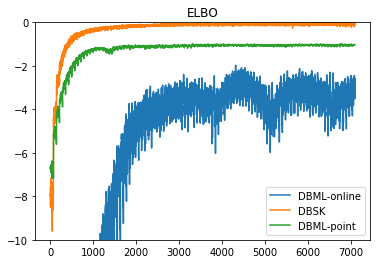

In [46]:
plt_x = [i*1 for i in range(len(elob_all_ml_t))]
plt.title('ELBO')
plt.ylim((-10,0))
plt.plot(plt_x, elob_all_ml_t, label = 'DBML-online')
plt.plot(plt_x, elob_all_sk, label = 'DBSK')
plt.plot(plt_x, elob_all_dis, label = 'DBML-point')
plt.legend()

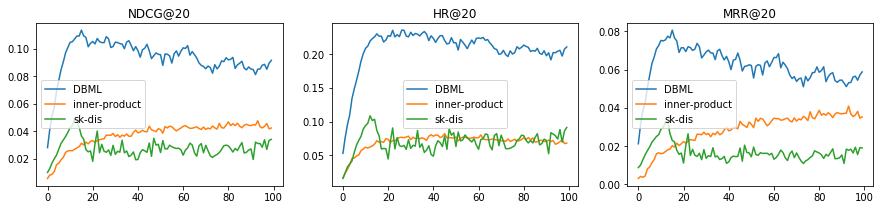

In [47]:
plt.figure(figsize=(15,3))
plt.subplot(131)
plt_x = [i*1 for i in range(len(ndcg_all_ml))]
plt.title('NDCG@20')
plt.plot(plt_x, ndcg_all_ml, label = 'DBML')
plt.plot(plt_x, ndcg_all_sk, label = 'inner-product')
plt.plot(plt_x, ndcg_all_dis, label = 'sk-dis')
plt.legend()
plt.subplot(132)
plt.title('HR@20')
plt_x = [i*1 for i in range(len(mrr_all_dis))]
plt.plot(plt_x, hr_all_ml, label = 'DBML')
plt.plot(plt_x, hr_all_sk, label = 'inner-product')
plt.plot(plt_x, hr_all_dis, label = 'sk-dis')
plt.legend()
plt.subplot(133)
plt.title('MRR@20')
plt_x = [i*1 for i in range(len(mrr_all_dis))]
plt.plot(plt_x, mrr_all_ml, label = 'DBML')
plt.plot(plt_x, mrr_all_sk, label = 'inner-product')
plt.plot(plt_x, mrr_all_dis, label = 'sk-dis')
plt.legend()

In [45]:
utrain = set()
for i in datasets.train_data:
    if (i[-1] == 17):
        utrain.add(i[0])
utest = set()
for i in datasets.test_data:
    if (i[-1] == 17):
        utest.add(i[0])

In [46]:
len(datasets.train_data), len(datasets.test_data)

(172590, 27879)

In [47]:
len(utrain), len(utest)

(9733, 16473)

In [87]:
torch.save(model.state_dict(), '../his/'+data_name+'_dynamic_word.pkl')
import pickle
'''
保存文件
'''
with open('../his/user_time_latent_'+data_name+'_dynamic_with_word.bin', 'wb+') as f:
    pickle.dump(user_time_latent,f)
with open('../his/product_time_latent_'+data_name+'_dynamic_with_word.bin', 'wb+') as f:
    pickle.dump(product_time_latent,f)
with open('../his/word_time_latent_'+data_name+'_dynamic_with_word.bin', 'wb+') as f:
    pickle.dump(word_time_latent,f)
with open('../his/word_trans_linear_'+data_name+'_dynamic_with_word.bin', 'wb+') as f:
    pickle.dump(word_trans_linear, f)

In [88]:
# import pickle
# with open('../his/user_time_latent_'+data_name+'_dynamic_with_word.bin', 'rb') as f:
#     user_time_latent = pickle.load(f)
# with open('../his/product_time_latent_'+data_name+'_dynamic_with_word.bin', 'rb') as f:
#     product_time_latent = pickle.load(f)
# with open('../his/word_time_latent_'+data_name+'_dynamic_with_word.bin', 'rb') as f:
#     word_time_latent = pickle.load(f)
# with open('../his/word_trans_linear_'+data_name+'_dynamic_with_word.bin', 'rb') as f:
#     word_trans_linear = pickle.load(f)

In [14]:
def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.
def mean_reciprocal_rank(r):
    return np.sum(r / np.arange(1, r.size + 1))
def hit_rate(r):
    if (np.sum(r) >= 0.9):
        return 1
    else:
        return 0

In [16]:
from tqdm import trange

In [17]:
len(eval_dataset)

NameError: name 'eval_dataset' is not defined

In [ ]:
#.  0    1         2        3        4         5       6
# (uid, pid_pos, qids_pos, len_pos, text_ids, len_r, time_bin_pos)
all_p_m = torch.empty(time_bin_num+1, datasets.productNum, embedding_dim)
for ii in range(time_bin_num+1):
    k = 0
    for i in product_time_latent[ii].values():
        all_p_m[ii][k] = i[0]
        k+=1
eval_dataset = datasets.test_data
test_counter = 0
all_hr = 0
all_ndcg = 0
all_mrr = 0
for ii in trange(len(eval_dataset)):
    td = eval_dataset[ii]
    '''
    应该定义一个训练过的user， 这里简单的先取训练过的时间段的用户
    '''
    if (td[6] >= start_time_bin):
        user = user_time_latent[td[6]+1][td[0]][0]
        product = product_time_latent[td[6]+1][td[1]][0]
        query_len = td[3]
        query = torch.cat(tuple([word_time_latent[td[6]+1][i][0] for i in td[2]])).view(1,-1,embedding_dim)
        query = get_query_laten(word_trans_linear[td[6]+1], query, query_len, datasets.max_query_len)
        user_query = user+query
#         uq_i = torch.empty(datasets.productNum)
        user_query.squeeze_(0)
        uq_i = (user_query - all_p_m[td[6]+1]).norm(2, dim=1)*(-1.)
#         for i in range(datasets.productNum):
#             p_mean = product_time_latent[td[6]+1][i][0]
#             uq_i[i] = -1*(user_query-p_mean).norm(2).item()
        ranks_order = uq_i.topk(20)[1]
        r = torch.eq(ranks_order, td[1]).numpy()
        all_hr += hit_rate(r)
        all_mrr += mean_reciprocal_rank(r)
        all_ndcg += dcg_at_k(r, 20, 1)
        test_counter += 1
hr = all_hr / float(test_counter)
mrr = all_mrr / float(test_counter)
ndcg = all_ndcg / float(test_counter)

 86%|████████▌ | 16620/19403 [2:01:41<18:01,  2.57it/s]  

In [62]:
1 in used_u

True

In [19]:
hr, mrr, ndcg

(0.31333333333333335, 0.11096595071595074, 0.15635418538487844)

In [81]:
hr, mrr, ndcg

(0.38, 0.12505333214543743, 0.18218913345225057)